In [1]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16,ResNet50,DenseNet201,ResNet152V2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import shutil
import cv2
import os
import time
import tensorflow as tf
random_value=42 #setting randomness at fixed for every run
from sklearn import metrics
from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.tf2.attacks.fgnm import fgnm
from cleverhans.tf2.attacks.pgdnm import pgdnm
from cleverhans.tf2.attacks.bimnm import bimnm
from cleverhans.tf2.attacks.basic_iterative_method import basic_iterative_method

from math import log
c = time.time()
data = np.load("data1.npy")
labels = np.load("label_precess.npy")
d = time.time()
print(d-c)
(trainX1, testX1, trainY1, testY1) = train_test_split(data, labels, test_size=0.2,stratify=labels, random_state=random_value)
# initialize the training data augmentation object
print("Size of train image : {} and train label : {}".format(len(trainX1),len(trainY1)))
print("Size of test image : {} and test label : {}".format(len(testX1),len(testY1)))
trainX = tf.convert_to_tensor(trainX1)
testX = tf.convert_to_tensor(testX1)
trainY = tf.convert_to_tensor(trainY1)
testY = tf.convert_to_tensor(testY1)
testX2 = tf.cast(testX,dtype=tf.float32)

2022-05-20 18:16:50.608180: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


1.9333577156066895
Size of train image : 3600 and train label : 3600
Size of test image : 900 and test label : 900


2022-05-20 18:16:55.515817: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-05-20 18:16:55.614394: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:61:00.0 name: NVIDIA A40 computeCapability: 8.6
coreClock: 1.74GHz coreCount: 84 deviceMemorySize: 44.37GiB deviceMemoryBandwidth: 648.29GiB/s
2022-05-20 18:16:55.614417: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-05-20 18:16:55.632358: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-05-20 18:16:55.632426: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-05-20 18:16:55.634026: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2022

In [2]:
model_vgg=tf.keras.models.load_model('./fine-tune-vgg.h5')
# predict_vgg16=np.argmax(model_vgg.predict(testX),1)
# print("VGG16 acc:{}".format(metrics.accuracy_score(np.argmax(testY,1),predict_vgg16)))
model_iv3=tf.keras.models.load_model('fine-tune-iv3.h5')
# predict_iv3=np.argmax(model_iv3.predict(testX),1)
# print("iv3 acc:{}".format(metrics.accuracy_score(np.argmax(testY,1),predict_iv3)))
model_den=tf.keras.models.load_model('fine-tune-den.h5')
# predict_den=np.argmax(model_den.predict(testX),1)
# print("den acc:{}".format(metrics.accuracy_score(np.argmax(testY,1),predict_den)))

In [3]:
def acc(realdata,pred):
    real_label = np.argmax(realdata,axis=1)
    #pred = np.argmax(pred,axis=1)
    return metrics.accuracy_score(real_label,pred)

###这里还要记录攻击过后图像本身的值
#  我们不只需要攻击过后在白盒测试上的结果，我们还需要黑盒测试的结果。 
def pgd(model_white,model_black1,model_black2,x,K,eps,eps_iter,nb_iter,targeted=False):
    pred_total_vgg = []
    pred_total_iv3 = []
    pred_total_den = []
    for i in range(len(x)//K+1): 
        S = i*K
        if S>=len(x):
            break
        E = (i+1)*K
        if E>len(x):
            E = len(x)
        temp_image = x[S:E].numpy().reshape(E-S,224,224,3)
        temp_image_withatk = projected_gradient_descent(model_white, temp_image,eps,eps_iter,nb_iter,np.inf,targeted=False) ##分批次攻击
        
        pred_vgg = model_white.predict(temp_image_withatk)
        pred_vgg =  list(np.argmax(pred_vgg,axis=1))
        #pred_total_vgg.append(pred_vgg)
        pred_total_vgg+=pred_vgg
        
        pred_iv3 = model_black1.predict(temp_image_withatk)
        pred_iv3 =  list(np.argmax(pred_iv3,axis=1))
        pred_total_iv3+=pred_iv3
        
        pred_den = model_black2.predict(temp_image_withatk)
        pred_den =  list(np.argmax(pred_den,axis=1))
        pred_total_den+=pred_den
        
    return pred_total_vgg, pred_total_iv3, pred_total_den


def pgd_nm(model_white,model_black1,model_black2,x,K,eps,eps_iter,nb_iter,targeted=False):
    pred_total_vgg = []
    pred_total_iv3 = []
    pred_total_den = []
    for i in range(len(x)//K+1): 
        S = i*K
        if S>=len(x):
            break
        E = (i+1)*K
        if E>len(x):
            E = len(x)
        temp_image = x[S:E].numpy().reshape(E-S,224,224,3)
        temp_image_withatk = pgdnm(model_white, temp_image,eps,eps_iter,nb_iter,np.inf,targeted=False)
        
        pred_vgg = model_white.predict(temp_image_withatk)
        pred_vgg =  list(np.argmax(pred_vgg,axis=1))
        #pred_total_vgg.append(pred_vgg)
        pred_total_vgg+=pred_vgg
        
        pred_iv3 = model_black1.predict(temp_image_withatk)
        pred_iv3 =  list(np.argmax(pred_iv3,axis=1))
        pred_total_iv3+=pred_iv3
        
        pred_den = model_black2.predict(temp_image_withatk)
        pred_den =  list(np.argmax(pred_den,axis=1))
        pred_total_den+=pred_den
             
    return pred_total_vgg, pred_total_iv3, pred_total_den

def fgm(model_white,model_black1,model_black2,x,K,eps):
    pred_total_vgg = []
    pred_total_iv3 = []
    pred_total_den = []
    for i in range(len(x)//K+1): 
        S = i*K
        if S>=len(x):
            break
        E = (i+1)*K
        if E>len(x):
            E = len(x)
        temp_image = x[S:E].numpy().reshape(E-S,224,224,3)
        temp_image_withatk = fast_gradient_method(model_white, temp_image,eps,np.inf,targeted=False)
        
        pred_vgg = model_white.predict(temp_image_withatk)
        pred_vgg =  list(np.argmax(pred_vgg,axis=1))
        #pred_total_vgg.append(pred_vgg)
        pred_total_vgg+=pred_vgg
        
        pred_iv3 = model_black1.predict(temp_image_withatk)
        pred_iv3 =  list(np.argmax(pred_iv3,axis=1))
        pred_total_iv3+=pred_iv3
        
        pred_den = model_black2.predict(temp_image_withatk)
        pred_den =  list(np.argmax(pred_den,axis=1))
        pred_total_den+=pred_den
             
    return pred_total_vgg, pred_total_iv3, pred_total_den
def fgm_nm(model_white,model_black1,model_black2,x,K,eps):
    pred_total_vgg = []
    pred_total_iv3 = []
    pred_total_den = []
    for i in range(len(x)//K+1): 
        S = i*K
        if S>=len(x):
            break
        E = (i+1)*K
        if E>len(x):
            E = len(x)
        temp_image = x[S:E].numpy().reshape(E-S,224,224,3)
        temp_image_withatk = fgnm(model_white, temp_image,eps,np.inf,targeted=False)
        pred_vgg = model_white.predict(temp_image_withatk)
        pred_vgg =  list(np.argmax(pred_vgg,axis=1))
        #pred_total_vgg.append(pred_vgg)
        pred_total_vgg+=pred_vgg
        
        pred_iv3 = model_black1.predict(temp_image_withatk)
        pred_iv3 =  list(np.argmax(pred_iv3,axis=1))
        pred_total_iv3+=pred_iv3
        
        pred_den = model_black2.predict(temp_image_withatk)
        pred_den =  list(np.argmax(pred_den,axis=1))
        pred_total_den+=pred_den
             
    return pred_total_vgg, pred_total_iv3, pred_total_den
def bim(model_white,model_black1,model_black2,x,K,eps,eps_iter,nb_iter,targeted=False):
    pred_total_vgg = []
    pred_total_iv3 = []
    pred_total_den = []
    for i in range(len(x)//K+1): 
        S = i*K
        if S>=len(x):
            break
        E = (i+1)*K
        if E>len(x):
            E = len(x)
        temp_image = x[S:E].numpy().reshape(E-S,224,224,3)
        temp_image_withatk = basic_iterative_method(model_white,temp_image,eps,eps_iter,nb_iter,np.inf,targeted=False)
        pred_vgg = model_white.predict(temp_image_withatk)
        pred_vgg =  list(np.argmax(pred_vgg,axis=1))
        #pred_total_vgg.append(pred_vgg)
        pred_total_vgg+=pred_vgg
        pred_iv3 = model_black1.predict(temp_image_withatk)
        pred_iv3 =  list(np.argmax(pred_iv3,axis=1))
        pred_total_iv3+=pred_iv3
        
        pred_den = model_black2.predict(temp_image_withatk)
        pred_den =  list(np.argmax(pred_den,axis=1))
        pred_total_den+=pred_den
    return pred_total_vgg, pred_total_iv3, pred_total_den
def bim_nm(model_white,model_black1,model_black2,x,K,eps,eps_iter,nb_iter,targeted=False):
    pred_total_vgg = []
    pred_total_iv3 = []
    pred_total_den = []
    for i in range(len(x)//K+1): 
        S = i*K
        if S>=len(x):
            break
        E = (i+1)*K
        if E>len(x):
            E = len(x)
        temp_image = x[S:E].numpy().reshape(E-S,224,224,3)
        temp_image_withatk = bimnm(model_white,temp_image,eps,eps_iter,nb_iter,np.inf,targeted=False)
        pred_vgg = model_white.predict(temp_image_withatk)
        pred_vgg =  list(np.argmax(pred_vgg,axis=1))
        #pred_total_vgg.append(pred_vgg)
        pred_total_vgg+=pred_vgg  
        
        pred_iv3 = model_black1.predict(temp_image_withatk)
        pred_iv3 =  list(np.argmax(pred_iv3,axis=1))
        pred_total_iv3+=pred_iv3
        
        pred_den = model_black2.predict(temp_image_withatk)
        pred_den =  list(np.argmax(pred_den,axis=1))
        pred_total_den+=pred_den
    return pred_total_vgg, pred_total_iv3, pred_total_den

In [20]:
pred_pgdnm= pgd_nm(model_vgg,model_iv3,model_den,testX[0:10],100,1,0.00003,10) 
pred_pgd = pgd(model_vgg,model_iv3,model_den,testX[0:10],100,1,0.00003,10)

In [21]:
pred_bimnm= bim_nm(model_vgg,model_iv3,model_den,testX[0:10],100,1,0.00003,10) 
pred_bim = bim(model_vgg,model_iv3,model_den,testX[0:10],100,1,0.00003,10)

In [39]:
pred_fgm = fgm(model_den,testX,100,0.001)
pred_fgmnm = fgm_nm(model_den,testX,100,0.001)

In [40]:
print(metrics.accuracy_score(pred_fgmnm,np.argmax(testY,axis=1)))
metrics.accuracy_score(pred_fgm,np.argmax(testY,axis=1))

0.6944444444444444


0.6722222222222223

In [41]:
# pgd1 = []
# pgdnm1 = []
# fgm1 = []
# fgnm1 = []
eps_fgsm = [0, 0.0005, 0.001, 0.002, 0.004, 0.006, 0.008, 0.01, 0.02, 0.03]
for i in eps_fgsm:
    print("*********************当前eps = {}*******************************".format(i))
    pred_fgm,a,b = fgm(model_vgg,model_iv3,model_den,testX,100,i)
    pred_fgnm,c,d = fgm_nm(model_vgg,model_iv3,model_den,testX,100,i)
    acc_fgnm = metrics.accuracy_score(pred_fgnm,np.argmax(testY,axis=1))
    acc_fgm = metrics.accuracy_score(pred_fgm,np.argmax(testY,axis=1))
    print("白盒-fgm")
    print(acc_fgm,acc_fgnm)
    print("黑盒-fgm")
    print("fgm中iv3 = {},den={}".format(metrics.accuracy_score(a,np.argmax(testY,axis=1)),metrics.accuracy_score(b,np.argmax(testY,axis=1))))
    print("fgnm中iv3 = {},den={}".format(metrics.accuracy_score(c,np.argmax(testY,axis=1)),metrics.accuracy_score(d,np.argmax(testY,axis=1))))
    


*********************当前eps = 0*******************************
白盒-fgm
0.9222222222222223 0.9222222222222223
黑盒-fgm
fgm中iv3 = 0.9011111111111111,den=0.9677777777777777
fgnm中iv3 = 0.9011111111111111,den=0.9677777777777777
*********************当前eps = 0.0005*******************************
白盒-fgm
0.8844444444444445 0.7844444444444445
黑盒-fgm
fgm中iv3 = 0.8966666666666666,den=0.9677777777777777
fgnm中iv3 = 0.8977777777777778,den=0.9622222222222222
*********************当前eps = 0.001*******************************
白盒-fgm
0.7788888888888889 0.5566666666666666
黑盒-fgm
fgm中iv3 = 0.8922222222222222,den=0.9622222222222222
fgnm中iv3 = 0.8877777777777778,den=0.95
*********************当前eps = 0.002*******************************
白盒-fgm
0.5422222222222223 0.24444444444444444
黑盒-fgm
fgm中iv3 = 0.8788888888888889,den=0.9422222222222222
fgnm中iv3 = 0.8666666666666667,den=0.92
*********************当前eps = 0.004*******************************
白盒-fgm
0.2222222222222222 0.10111111111111111
黑盒-fgm
fgm中iv3 = 0.85,den=

In [45]:
eps_im = [0.00005, 0.0001,0.0002, 0.0003, 0.0006, 0.001, 0.003]
for i in eps_im:
    print("*********************当前eps = {}*******************************".format(i))
    pred_bimnm,a,b= bim_nm(model_vgg,model_iv3,model_den,testX,100,1,i,10) 
    pred_bim,c,d = bim(model_vgg,model_iv3,model_den,testX,100,1,i,10)
    acc_bim = metrics.accuracy_score(pred_bim,np.argmax(testY,axis=1))
    acc_bimnm = metrics.accuracy_score(pred_bimnm,np.argmax(testY,axis=1))
    print("白盒-bim")
    print(acc_bim,acc_bimnm)
    print("黑盒-bim")
    print("pgd中iv3 = {},den={}".format(metrics.accuracy_score(c,np.argmax(testY,axis=1)),metrics.accuracy_score(d,np.argmax(testY,axis=1))))
    print("pgdnm中iv3 = {},den={}".format(metrics.accuracy_score(a,np.argmax(testY,axis=1)),metrics.accuracy_score(b,np.argmax(testY,axis=1))))
    
    
    pred_pgdnm,a,b= pgd_nm(model_vgg,model_iv3,model_den,testX,100,1,i,10) 
    pred_pgd,c,d = pgd(model_vgg,model_iv3,model_den,testX,100,1,i,10)
    acc_pgd = metrics.accuracy_score(pred_pgd,np.argmax(testY,axis=1))
    acc_pgdnm = metrics.accuracy_score(pred_pgdnm,np.argmax(testY,axis=1))
    print("白盒-pgd")
    print(acc_pgd,acc_pgdnm)
    print("黑盒-pgd")
    print("pgd中iv3 = {},den={}".format(metrics.accuracy_score(c,np.argmax(testY,axis=1)),metrics.accuracy_score(d,np.argmax(testY,axis=1))))
    print("pgdnm中iv3 = {},den={}".format(metrics.accuracy_score(a,np.argmax(testY,axis=1)),metrics.accuracy_score(b,np.argmax(testY,axis=1))))
    

*********************当前eps = 5e-05*******************************
白盒-bim
0.8788888888888889 0.7622222222222222
黑盒-bim
pgd中iv3 = 0.8988888888888888,den=0.9666666666666667
pgdnm中iv3 = 0.8988888888888888,den=0.9655555555555555
白盒-pgd
0.8788888888888889 0.7611111111111111
黑盒-pgd
pgd中iv3 = 0.8988888888888888,den=0.9666666666666667
pgdnm中iv3 = 0.8988888888888888,den=0.9655555555555555
*********************当前eps = 0.0001*******************************
白盒-bim
0.76 0.4677777777777778
黑盒-bim
pgd中iv3 = 0.8933333333333333,den=0.9633333333333334
pgdnm中iv3 = 0.8911111111111111,den=0.9522222222222222
白盒-pgd
0.76 0.4677777777777778
黑盒-pgd
pgd中iv3 = 0.8933333333333333,den=0.9633333333333334
pgdnm中iv3 = 0.8911111111111111,den=0.9522222222222222
*********************当前eps = 0.0002*******************************
白盒-bim
0.45555555555555555 0.12222222222222222
黑盒-bim
pgd中iv3 = 0.8844444444444445,den=0.9466666666666667
pgdnm中iv3 = 0.8633333333333333,den=0.9288888888888889
白盒-pgd
0.45555555555555555 0.1222222

KeyboardInterrupt: 

In [46]:
eps_draw = []
for i in range(1,31):
    if i<11:
        eps_draw.append(i*0.00001)
    elif i<21:
        eps_draw.append((i-10)*0.0001)
    else:
        eps_draw.append((i-20)*0.001) 

In [125]:
pgd1 = []
pgdnm1 = []
fgm1 = []

fgnm1 = []

for i in eps_draw:
    print("*********************当前eps = {}*******************************".format(i))
    pred_fgm,_,_ = fgm(model_vgg,model_iv3,model_den,testX,100,i)
    pred_fgnm,_,_ = fgm_nm(model_vgg,model_iv3,model_den,testX,100,i)
    acc_fgnm = metrics.accuracy_score(pred_fgnm,np.argmax(testY,axis=1))
    acc_fgm = metrics.accuracy_score(pred_fgm,np.argmax(testY,axis=1))
    print("白盒-fgm")
    print(acc_fgm,acc_fgnm)
    
    pred_pgd,_,_ = pgd(model_vgg,model_iv3,model_den,testX,100,1,i,10)
    pred_pgdnm,_,_= pgd_nm(model_vgg,model_iv3,model_den,testX,100,1,i,10) 
    acc_pgd = metrics.accuracy_score(pred_pgd,np.argmax(testY,axis=1))
    acc_pgdnm = metrics.accuracy_score(pred_pgdnm,np.argmax(testY,axis=1))
    print("白盒-pgd")
    print(acc_pgd,acc_pgdnm)
    
    fgm1.append(acc_fgm)
    fgnm1.append(acc_fgnm)
    pgd1.append(acc_pgd)
    pgdnm1.append(acc_pgdnm)

NameError: name 'eps_draw' is not defined

In [49]:
np.save('fgm.npy',fgm1)
np.save('fgnm.npy',fgnm1)


np.save('pgd.npy',pgd1)
np.save('pgdnm.npy',pgdnm1)

print(pgdnm1)
print()
print(fgnm1)

[0.9033333333333333, 0.8977777777777778, 0.8655555555555555, 0.8177777777777778, 0.7633333333333333, 0.7044444444444444, 0.6522222222222223, 0.5933333333333334, 0.5322222222222223, 0.4677777777777778, 0.4677777777777778, 0.12222222222222222, 0.07222222222222222, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.06888888888888889, 0.07, 0.07, 0.07111111111111111, 0.07111111111111111, 0.07111111111111111, 0.07111111111111111, 0.07111111111111111]

[0.92, 0.9177777777777778, 0.9155555555555556, 0.9122222222222223, 0.9066666666666666, 0.9077777777777778, 0.9066666666666666, 0.9055555555555556, 0.9, 0.9011111111111111, 0.9011111111111111, 0.8977777777777778, 0.8688888888888889, 0.8277777777777777, 0.7844444444444445, 0.7322222222222222, 0.6833333333333333, 0.6377777777777778, 0.5955555555555555, 0.5566666666666666, 0.5566666666666666, 0.24444444444444444, 0.13, 0.10111111111111111, 0.08555555555555555, 0.0811111111111111, 0.07888888888888888, 0.07777777777777778, 0.07666666666666666, 

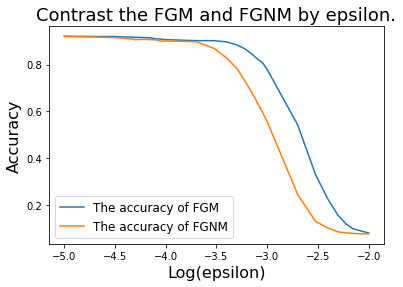

In [126]:
eps_draw41 = []
for i in range(1,31):
    if i<11:
        eps_draw41.append(i*0.0001)
    elif i<21:
        eps_draw41.append((i-10)*0.001)
    else:
        eps_draw41.append((i-20)*0.01) 

fgm41 = []
fgnm41 = []


for i in eps_draw41:
    print("*********************当前eps = {}*******************************".format(i))
    pred_fgm,_,_ = fgm(model_vgg,model_iv3,model_den,testX,100,i)
    pred_fgnm,_,_ = fgm_nm(model_vgg,model_iv3,model_den,testX,100,i)
    acc_fgnm = metrics.accuracy_score(pred_fgnm,np.argmax(testY,axis=1))
    acc_fgm = metrics.accuracy_score(pred_fgm,np.argmax(testY,axis=1))
    print("白盒-fgm")
    print(acc_fgm,acc_fgnm)
    fgm41.append(acc_fgm)
    fgnm41.append(acc_fgnm)
    
print(fgm41)
print()
print(fgnm41)

*********************当前eps = 0.0001*******************************
白盒-fgm
0.9066666666666666 0.9011111111111111
*********************当前eps = 0.0002*******************************
白盒-fgm
0.9022222222222223 0.8977777777777778
*********************当前eps = 0.00030000000000000003*******************************
白盒-fgm
0.9022222222222223 0.8688888888888889
*********************当前eps = 0.0004*******************************
白盒-fgm
0.8966666666666666 0.8277777777777777
*********************当前eps = 0.0005*******************************
白盒-fgm
0.8844444444444445 0.7844444444444445
*********************当前eps = 0.0006000000000000001*******************************
白盒-fgm
0.8677777777777778 0.7322222222222222
*********************当前eps = 0.0007*******************************
白盒-fgm
0.8466666666666667 0.6833333333333333
*********************当前eps = 0.0008*******************************
白盒-fgm
0.8244444444444444 0.6377777777777778
*********************当前eps = 0.0009000000000000001***********************

In [5]:
# np.save('fgm1.npy',fgm41)
# np.save('fgnm1.npy',fgnm41)

fgm = np.load('fgm1.npy')
fgnm = np.load('fgnm1.npy')

In [6]:
eps_fgsm = []
for i in range(1,31):
    if i<11:
        eps_fgsm.append(i*0.0001)
    elif i<21:
        eps_fgsm.append((i-10)*0.001)
    else:
        eps_fgsm.append((i-20)*0.01)

In [7]:
eps_log = []
for i in eps_fgsm:
    eps_log.append(log(i,10))
    
fig=plt.figure(figsize=(24, 16),dpi=500)
legend=['The accuracy of FGSM',"The accuracy of FGNM"]
plt.plot(eps_log,fgm, linewidth=7.5)
plt.plot(eps_log,fgnm, linewidth=7.5)
plt.title("Comparison of FGSM and FGNM", fontsize=85)
plt.xlabel("Log(epsilon)", fontsize=70)
plt.ylabel("Accuracy", fontsize=70)
plt.legend(legend, fontsize=55)
plt.tick_params(labelsize=45) 
plt.savefig('Comparison of FGSM and FGNM.')
plt.show()

In [8]:
pgd = np.load('pgd.npy')
pgdnm = np.load('pgdnm.npy')

eps_pgd = []
for i in range(1,31):
    if i<11:
        eps_pgd.append(i*0.00001)
    elif i<21:
        eps_pgd.append((i-10)*0.0001)
    else:
        eps_pgd.append((i-20)*0.001)

In [9]:
eps_log = []
for i in eps_pgd:
    eps_log.append(log(i,10))
    
fig=plt.figure(figsize=(24, 16),dpi=500)
legend=['The accuracy of PGD',"The accuracy of PGDNM"]
plt.plot(eps_log,pgd, linewidth=7.5)
plt.plot(eps_log,pgdnm, linewidth=7.5)
plt.title("Comparison of PGD and PGDNM", fontsize=85)
plt.xlabel("Log(epsilon)", fontsize=70)
plt.ylabel("Accuracy", fontsize=70)
plt.legend(legend, fontsize=55)
plt.tick_params(labelsize=45) 
plt.savefig('Comparison of PGD and PGDNM.')
plt.show()

In [168]:
# 计算扰动    226
x = 757
adv_bimnm = bimnm(model_vgg,testX2[x:x+1],1,0.0003,20,np.inf,targeted=False)
adv2 = bimnm(model_vgg,testX2[x:x+1],1,0.003,20,np.inf,targeted=False)
s = model_vgg.predict(adv_bimnm)
s = list(np.argmax(s,1))
s2 = np.argmax(model_vgg.predict(adv2),1)
imageatk = adv_bimnm[0].numpy()
imageatk2 = adv2[0].numpy()
imageori = testX2[x].numpy()
imagecha = imageatk - imageori
imagecha2 = imageatk2 - imageori

In [10]:
columns = 5
rows = 1
size = 30

fig=plt.figure(figsize=(40, 20),dpi=500)
fig.add_subplot(rows,columns,1)
plt.imshow(imageori)
# plt.title("Original image",fontsize=size)
plt.xlabel("(a) Original image \n Class COVID".format(np.argmax(np.array(testY[x]))),fontsize=size)

fig.add_subplot(rows,columns,2)
plt.imshow(imagecha*100)
# plt.title("Perturbation1",fontsize=size)
plt.xlabel("(b) Perturbation1 \n Epsilon = {}".format(0.0003),fontsize=size)

fig.add_subplot(rows,columns,3)
plt.imshow(imageatk)
# plt.title("Successful attack",fontsize=size)
plt.xlabel("(c) Successful attack \n Class NORMAL".format(s),fontsize=size)

fig.add_subplot(rows,columns,4)
plt.imshow(imagecha2*100)
# plt.title("Perturbation2",fontsize=size)
plt.xlabel("(d) Perturbation2 \n Epsilon = {}".format(0.003),fontsize=size)

fig.add_subplot(rows,columns,5)
plt.imshow(imageatk2)
# plt.title("Failed attack",fontsize=size)
plt.xlabel("(e) Failed attack \n Class NORMAL".format(s2),fontsize=size)

#plt.xlabel("Predict Error",color = 'b',size = 'x-large')

plt.savefig("eps=5图并排binm.png")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [11]:
# 计算扰动    226
x = 23
adv_fgnm = fgnm(model_vgg, testX2[x:x+1],0.003,np.inf,targeted=False)
adv1 = fgnm(model_vgg, testX2[x:x+1],0.03,np.inf,targeted=False)
s = model_vgg.predict(adv_fgnm)
s = list(np.argmax(s,1))
s2 = np.argmax(model_vgg.predict(adv1),1)
imageatk = adv_fgnm[0].numpy()
imageatk2 = adv1[0].numpy()
imageori = testX2[x].numpy()
imagecha = imageatk - imageori
imagecha2 = imageatk2 - imageori

In [12]:
columns = 5
rows = 1
size = 30

fig=plt.figure(figsize=(40, 20),dpi=500)
fig.add_subplot(rows,columns,1)
plt.imshow(imageori)
# plt.title("Original image",fontsize=size)
plt.xlabel("(a) Original image \n Class COVID".format(np.argmax(np.array(testY[x]))),fontsize=size)

fig.add_subplot(rows,columns,2)
plt.imshow(imagecha*100)
# plt.title("Perturbation1",fontsize=size)
plt.xlabel("(b) Perturbation1 \n Epsilon = {}".format(0.003),fontsize=size)

fig.add_subplot(rows,columns,3)
plt.imshow(imageatk)
# plt.title("Successful attack",fontsize=size)
plt.xlabel("(c) Successful attack \n Class NORMAL".format(s),fontsize=size)

fig.add_subplot(rows,columns,4)
plt.imshow(imagecha2*100)
# plt.title("Perturbation2",fontsize=size)
plt.xlabel("(d) Perturbation2 \n Epsilon = {}".format(0.03),fontsize=size)

fig.add_subplot(rows,columns,5)
plt.imshow(imageatk2)
# plt.title("Failed attack",fontsize=size)
plt.xlabel("(e) Failed attack \n Class NORMAL".format(s2),fontsize=size)

#plt.xlabel("Predict Error",color = 'b',size = 'x-large')

plt.savefig("eps=5图并排fgnm.png")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 0, 'Class 0 \n (a)')

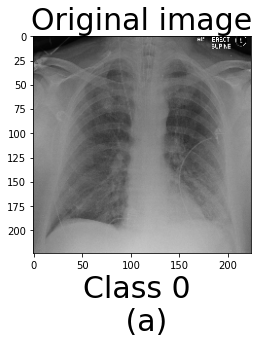

In [8]:
# 11   23  757
x = 757
imageori = testX2[x].numpy()

plt.imshow(imageori)
plt.title("Original image",fontsize=size)
plt.xlabel("Class {} \n (a)".format(np.argmax(np.array(testY[x]))),fontsize=size)

In [49]:
### FGSM FGNM
### model VGG16      model2 Densenet        model4    Incv3
testX2 = tf.cast(testX,dtype=tf.float32)
# ,clip_min=0,clip_max=1
eps = [0, 0.001, 0.002, 0.004, 0.005,0.006, 0.008, 0.01, 0.015, 0.02, 0.03,0.05,0.07,0.09,0.1]
#eps1 = [0.004,0.005,0.006,0.007,0.008,0.009,0.01]
for i in eps:
    pred_fgsm = fgm(model_vgg,testX,i)
    pred_fgsmnm = fgm_nm(model_vgg,testX,i)
    print("epsilon = {}".format(i))
    print("-----------VGG fgsm------------")
    pp(model_vgg,pred_fgsm)
    print("------------VGG fgnm------------")
    pp(model_vgg,pred_fgsmnm)
    print("-----------IV3 fgsm------------")
    pp(model_iv3,pred_fgsm)
    print("------------IV3 fgnm------------")
    pp(model_iv3,pred_fgsmnm)
    print("-----------DEN fgsm------------")
    pp(model_den,pred_fgsm)
    print("------------DEN fgnm------------")
    pp(model_den,pred_fgsmnm)
    print("**********************************************")


NameError: name 'fgm' is not defined

In [22]:
testX2 = tf.cast(testX,dtype=tf.float32)
# adv_pgd = projected_gradient_descent(model4, testX2,1, 0.1,10, 2, targeted=False)
# adv_pgdnm  = pgdnm(model4, testX2,1, 0.1,10, 2, targeted=False)
# adv_fgm = fast_gradient_method(model4, testX, 1, 2, targeted=False)
# adv_fgnm = fgnm(model4,testX,1, 2, targeted=False)
# adv_bim = basic_iterative_method(model4,testX2,1,0.1,10,2,targeted=False)
# adv_bimnm = bimnm(model4,testX2,1,0.1,10,2,targeted=False)
# 

# 生成对抗样本  model是攻击的model
def create_adv(model,X,eps,eps_iter,nb_iter):    
    adv_pgd = projected_gradient_descent(model, X,eps,eps_iter,nb_iter,np.inf,targeted=False)
    adv_pgdnm  = pgdnm(model,X,eps,eps_iter,nb_iter,np.inf,targeted=False)
    # adv_fgm = fast_gradient_method(model, X,eps,np.inf,targeted=False)
    # adv_fgnm = fgnm(model,X,eps, np.inf,targeted=False)
    adv_bim = basic_iterative_method(model,X,eps,eps_iter,nb_iter,np.inf,targeted=False)
    adv_bimnm = bimnm(model,X,eps,eps_iter,nb_iter,np.inf,targeted=False)
    return adv_pgd,adv_pgdnm,adv_bim,adv_bimnm

# 真实情况与对抗后的样本对比  model这里是测试的model
def pp(model,x):
    real_pred = model.predict(testX)
    real_pred = np.argmax(real_pred,axis=1)
    real_label = np.argmax(testY,axis=1)
    adv_alg_pred = model.predict(x)
    pred_with_atk = np.argmax(adv_alg_pred,axis=1)
    print()
    from sklearn import metrics
    print("对抗后的预测精度为{}".format(metrics.accuracy_score(pred_with_atk,real_label)))
    print("原来的预测精度为{}".format(metrics.accuracy_score(real_pred,real_label)))
    return metrics.accuracy_score(pred_with_atk,real_label),metrics.accuracy_score(real_pred,real_label)
    
# 给一个测试情况下的model
def printf(model):
    # print("-----------fgm------------")
    # pp(model,adv_fgm)
    # print("------------fgnm------------")
    # pp(model,adv_fgnm)
    print("-----------pgd------------")
    pp(model,adv_pgd)
    print("-----------pgdnm------------")
    pp(model,adv_pgdnm)
    print("------------bim--------------")
    pp(model,adv_bim)
    print("------------bimnm--------")
    pp(model,adv_bimnm)

In [23]:
iter_eps = [0.00001, 0.00003,0.00006, 0.0001, 0.0003, 0.0006, 0.001, 0.003]
for i in iter_eps:
    print("iter_eps = {}".format(i))
    print("VGG16--VGG16")
    adv_pgd,adv_pgdnm,adv_bim,adv_bimnm = create_adv(model1,testX2,1,i,20)
    printf(model1)
    print("VGG16--Inv3")
    #adv_fgm,adv_fgnm,adv_pgd,adv_pgdnm,adv_bim,adv_bimnm = create_adv(model1,testX2,1,i,20)
    printf(model4)
    print("VGG16--Dens")
    #adv_fgm,adv_fgnm,adv_pgd,adv_pgdnm,adv_bim,adv_bimnm = create_adv(model1,testX2,1,i,20)
    printf(model2)
    print("****************************************************************************************")

iter_eps = 1e-05
VGG16--VGG16


NameError: name 'model1' is not defined

In [24]:
pred_pgd = pgd(model_vgg,testX,0.1,0.01,10)

NameError: name 'model_vgg' is not defined

In [4]:
pred_bim = bim(model_vgg,testX2,0.1,0.01,10)

In [15]:
print(np.array(pred_pgd).reshape(-1))

[1 0 1 1 1 1 0 1 1 1 2 1 1 1 0 1 0 1 1 1 0 0 1 2 1 1 0 0 0 0 1 1 0 1 0 0 0
 1 2 2 1 0 0 1 1 0 1 1 1 0 0 0 0 1 0 2 1 1 0 1 1 0 1 0 0 0 1 0 0 1 1 0 0 0
 1 0 1 0 0 0 0 1 1 1 0 1 1 0 0 0 0 1 2 1 1 2 0 0 1 1 0 1 0 0 0 1 0 1 0 1 2
 1 1 1 1 2 0 1 2 2 0 1 1 2 1 1 0 1 0 0 1 1 0 2 2 0 2 1 0 1 0 1 1 0 1 1 1 0
 0 0 1 0 0 0 0 0 0 2 1 0 0 0 1 0 1 0 0 0 0 1 0 1 0 1 1 2 1 1 0 0 0 0 1 0 0
 1 0 0 0 1 1 0 1 1 2 0 1 1 1 1 0 0 1 0 1 0 1 0 0 1 0 0 2 1 0 0 1 1 0 0 0 0
 1 2 1 0 0 1 0 0 2 0 1 0 1 0 1 0 2 1 0 1 0 1 0 1 1 0 0 0 1 0 1 1 0 1 1 0 1
 0 1 0 1 1 1 1 0 1 1 1 0 1 2 1 0 1 0 0 0 0 1 1 1 0 1 0 0 0 1 0 1 0 0 1 1 1
 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1 0 1 1 1 0 0 1 0 0 0 0 1 0 0 0 1 1 2 0 1 0 0
 0 1 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 0 1 1 0 0 1 1 0 1 1
 0 1 0 1 0 1 1 1 1 0 0 0 2 1 1 0 2 2 0 0 0 1 0 1 0 0 1 0 1 1 2 1 1 0 0 2 0
 0 1 1 1 1 2 0 1 1 1 1 1 0 1 1 1 0 0 0 1 1 0 1 0 0 1 0 1 0 1 1 1 1 0 1 1 1
 0 1 1 1 2 1 0 1 0 1 0 1 1 1 0 2 1 2 0 1 1 1 0 0 1 0 0 2 1 0 0 1 1 1 1 1 1
 1 0 1 1 1 0 1 0 1 0 1 0 

In [11]:
print(np.argmax(testY,1))

[0 2 2 0 0 2 1 0 0 2 0 0 0 0 2 0 1 0 0 0 2 2 0 0 2 2 1 1 1 2 0 0 2 0 1 2 1
 2 1 1 2 1 2 2 0 1 2 0 0 2 1 1 1 0 2 1 0 0 2 0 0 1 0 1 1 2 0 1 2 0 0 1 1 1
 0 1 0 1 2 1 0 2 2 0 2 0 0 1 1 1 2 0 1 0 0 0 1 1 1 2 1 2 1 1 1 0 1 0 1 0 1
 0 2 2 0 1 2 2 1 1 1 2 0 1 2 1 1 2 2 2 0 0 1 0 1 2 1 0 2 0 2 0 0 1 0 0 2 1
 2 1 2 2 1 2 2 2 1 0 1 2 1 2 0 2 2 1 0 2 1 2 0 2 2 0 2 1 1 0 1 1 1 2 0 2 2
 2 2 2 2 0 2 1 0 2 0 1 2 0 0 2 1 2 2 1 2 1 2 1 1 0 1 2 1 0 2 1 0 2 0 1 1 1
 2 1 0 1 1 0 1 2 1 2 0 1 0 1 0 2 1 0 1 0 1 0 2 0 0 1 2 1 2 1 0 2 2 0 0 2 2
 1 2 1 2 0 1 0 1 1 0 2 1 0 1 2 0 2 2 1 1 1 2 0 2 1 0 2 2 1 1 2 0 2 2 0 2 0
 0 1 2 1 2 1 2 1 1 0 1 2 1 0 2 1 2 0 0 2 2 0 2 1 1 1 0 1 2 1 0 0 1 0 0 2 2
 1 2 0 2 2 1 2 1 2 0 2 2 2 1 2 2 2 1 1 0 0 2 2 1 0 0 0 1 0 0 1 1 0 0 1 0 0
 1 0 2 2 2 2 2 2 0 2 1 1 1 0 0 2 1 1 1 0 0 2 2 2 2 1 0 1 1 0 1 0 2 1 1 1 1
 2 2 0 2 0 1 1 1 2 1 0 2 1 0 2 2 1 2 1 2 2 1 2 2 1 0 1 0 1 0 0 2 0 2 0 2 2
 1 0 0 0 1 2 0 0 2 0 0 0 2 2 1 1 2 0 2 0 0 0 2 1 0 1 2 1 0 1 2 0 0 0 2 2 2
 0 1 0 0 2 1 0 1 0 1 2 2 

In [17]:
print(metrics.accuracy_score(np.argmax(testY,1), np.array(pred_pgd).reshape(-1)))

0.043333333333333335


In [25]:
from cleverhans.tf2.attacks.fgnm import fgnm
from cleverhans.tf2.attacks.pgdnm import pgdnm
from cleverhans.tf2.attacks.bimnm import bimnm

ModuleNotFoundError: No module named 'cleverhans.tf2.attacks.fgnm'

In [24]:
print(len(pred_pgdnm))

900


In [22]:
print(metrics.accuracy_score(np.argmax(testY,1), np.array(pred_pgdnm).reshape(-1)))

0.2822222222222222


In [26]:
eps=[0.0005,0.0008,0.001, 0.002, 0.003,0.004, 0.005, 0.008, 0.01]
for i in eps:
    print(i)
    a = time.time()
    pred_fgsm = fgm(model_vgg,testX,i)
    pred_fgsmnm = fgm_nm(model_vgg,testX,i)
    print(metrics.accuracy_score(np.argmax(testY,1), np.array(pred_fgsm).reshape(-1)))
    print(metrics.accuracy_score(np.argmax(testY,1), np.array(pred_fgsmnm).reshape(-1)))
    b = time.time()
    print("time one eps:", b-a)
    print("\n")

0.0005


NameError: name 'fgm' is not defined

In [27]:
eps=[0.01, 0.015, 0.02, 0.03, 0.05, 0.08]
for i in eps:
    print(i)
    a = time.time()
    pred_fgsm = fgm(model_vgg,testX,i)
    pred_fgsmnm = fgm_nm(model_vgg,testX,i)
    print(metrics.accuracy_score(np.argmax(testY,1), np.array(pred_fgsm).reshape(-1)))
    print(metrics.accuracy_score(np.argmax(testY,1), np.array(pred_fgsmnm).reshape(-1)))
    b = time.time()
    print("time one eps:", b-a)
    print("\n")

0.01


NameError: name 'fgm' is not defined

In [28]:
iter_eps = [0.0003,0.0004,0.0005, 0.0006, 0.0008, 0.001, 0.003]
for i in iter_eps:
    print(i)
    a = time.time()
    pred_pgd = pgd(model_vgg,testX,1,i,20)
    pred_pgdnm = pgd_nm(model_vgg,testX,1,i,20)
    print(metrics.accuracy_score(np.argmax(testY,1), np.array(pred_pgd).reshape(-1)))
    print(metrics.accuracy_score(np.argmax(testY,1), np.array(pred_pgdnm).reshape(-1)))
    b = time.time()
    print("time one eps:", b-a)
    print("\n")

0.0003


NameError: name 'model_vgg' is not defined

In [ ]:
def pgd(model_white, model_black1, model_black2 ,x,eps,eps_iter,nb_iter,targeted=False):
    pred_total_vgg = []
    for i in x:
        temp_image = i.numpy().reshape(1,224,224,3)
        temp_image_withatk = projected_gradient_descent(model_white, temp_image,eps,eps_iter,nb_iter,np.inf,targeted=False)
        pred_vgg = model_white.predict(temp_image_withatk)
        pred_vgg =  np.argmax(pred_vgg,axis=1)
        pred_total_vgg.append(pred_vgg)
        
        pred_iv3 = model_black1.predict(temp_image_withatk)
        pred_iv3 =  np.argmax(pred_iv3,axis=1)
        pred_total_iv3.append(pred_iv3)
        
        pred_den = model_black2.predict(temp_image_withatk)
        pred_den =  np.argmax(pred_den,axis=1)
        pred_total_den.append(pred_den)
        
    return pred_total_vgg, pred_total_iv3, pred_total_den

###这里还要记录攻击过后图像本身的值
#  我们不只需要攻击过后在白盒测试上的结果，我们还需要黑盒测试的结果。 

0.9288888888888889